In [2]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.2 MB/s eta 0:00:00


In [3]:
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
import warnings
import camb
from tqdm import tqdm
warnings.filterwarnings("ignore")
'''
theta = [h0, ombh2, omch2, logAs, ns]
where As = 1e-10np.exp(logAs)
'''
def sim(theta):
    hubble = theta[0]*100
    As = 1e-10 * np.exp(theta[3])
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=hubble, ombh2=theta[1], omch2=theta[2])
    pars.InitPower.set_params(As=As, ns=theta[4])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    total = powers['total'][:, 0][2:2500]
    return total
    
def cov_matrix(vals):
    ells = np.arange(2501)[2:2500]
    V = np.diag(vals**2)*2 / ((2*ells+1))
    return V

@lru_cache(maxsize=64) 
def log_Likelihood_cached(theta_key):
    theta = np.array(theta_key)  
    return log_Likelihood_internal(theta)

def log_Likelihood(theta, data):
    theta_key = tuple(theta)
    return log_Likelihood_cached(theta_key)

def log_Likelihood_internal(theta):
  try:
    vals = sim(theta)
    d_minus_mu = np.subtract(vals, data)
    V = cov_matrix(vals)
    V_inv = np.linalg.inv(V)
    e_factor = -0.5 * np.matmul(d_minus_mu.T, np.matmul(V_inv, d_minus_mu))
    factor = np.sqrt(2 * np.pi * np.linalg.norm(V))
    result = e_factor - np.log(factor)
    return result
  except: 
    return -1e-15


data = sim([0.676, 0.0220, 0.122, 3.085, 0.964])

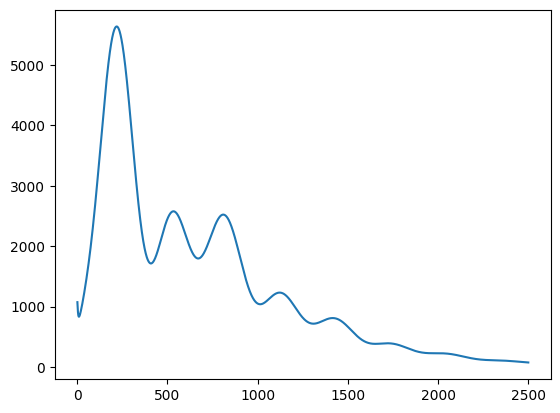

In [4]:
ells = np.arange(2501)[2:2500]
data_dls = ells*(ells+1) / (2*np.pi) * data
plt.plot(ells, data_dls)

In [5]:
def MH_sampler_5params(M,N,theta_in,sigma):
    h_accepted = []
    ombh2_accepted = []
    omch2_accepted = []
    As_accepted = []
    ns_accepted = []
    acceptance_likelihood = []
    Naccepted = []

    for i in range(M):
        Naccept = 0
        h_accept = [theta_in[0][i]]
        ombh2_accept     = [theta_in[1][i]]
        omch2_accept = [theta_in[2][i]]
        As_accept = [theta_in[3][i]]
        ns_accept = [theta_in[4][i]]
        acpt_lkhd    = []
        # theta_accept = np.array([alpha_accept, a_accept, b_accept, c_accept, d_accept, e_accept, f_accept])
        for j in tqdm(range(N)):  
            theta_accept = np.array([h_accept[-1], ombh2_accept[-1], omch2_accept[-1], As_accept[-1], ns_accept[-1]])
            #Generating random values of h and Omega_m in range (0,1) with Gaussian proposal distribution
            h_random = np.random.normal(h_accept[-1], sigma[0]) 
            ombh2_random     = np.random.normal(ombh2_accept[-1], sigma[1])
            omch2_random = np.random.normal(omch2_accept[-1], sigma[2]) 
            As_random = np.random.normal(As_accept[-1], sigma[3]) 
            ns_random = np.random.normal(ns_accept[-1], sigma[4])      
            theta_random = [h_random, ombh2_random, omch2_random,As_random,ns_random]   

            #Calulating log of likelihood of these randomly generated 
            new_log_L = log_Likelihood(theta_random, data)

            '''
            calulating acceptance probability and taking minimum of 1 and ratio of likelihood of new value of parameters to
            previous accepted values. If the ratio of likelihood is increased then it is accepted without condition.
            But if the likelihood goes down in next step then it would be accepted with uniform probability.
            '''

            acc_lkh = min(np.exp(new_log_L - log_Likelihood(theta_accept, data)), 1)

            if np.random.uniform(0, 1) < acc_lkh:
                h_accept   = np.append(h_accept, h_random)
                ombh2_accept       = np.append(ombh2_accept, ombh2_random)
                omch2_accept   = np.append(omch2_accept, omch2_random)
                As_accept   = np.append(As_accept, As_random)
                ns_accept   = np.append(ns_accept, ns_random)
                acpt_lkhd           = np.append(acpt_lkhd, new_log_L)
                Naccept+=1

        h_accepted.append(h_accept)
        ombh2_accepted.append(ombh2_accept)
        omch2_accepted.append(omch2_accept)
        As_accepted.append(As_accept)
        ns_accepted.append(ns_accept)
        #print(h_accepted)
        #print(ombh2_accepted)
        #print(omch2_accepted)
        #print(As_accepted)
        #print(ns_accepted)
        acceptance_likelihood.append(acpt_lkhd)
        Naccepted.append(Naccept)
        theta_accepted = np.array([h_accepted, ombh2_accepted, omch2_accepted, As_accepted, ns_accepted], dtype = object)
    return theta_accepted, acceptance_likelihood, Naccepted

In [ ]:
M = 10
N = 8000
sigma = [0.004, 0.0005, 0.001, 0.005, 0.003]
theta_in = np.array([[0.5, 0.6, 0.7, 0.8, 0.9],
                     [0.01, 0.022, 0.015, 0.025, 0.03],
                     [0.122, 0.01, 0.05, 0.2, 0.3],
                     [3.0, 3.10, 3.2, 3.08, 3.4],
                     [0.9, 0.95, 0.97, 0.96, 0.965]])
theta_accepted, acceptance_likelihood, Naccepted = MH_sampler_5params(M,N,theta_in, sigma)

  4%|███▍                                                                               | 334/8000 [09:31<3:32:52,  1.67s/it]